In [35]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from scipy.special import expit, logsumexp
from time import time
import scipy

sns.set(palette='Set2')

# LogLoss (theoretical)

*Постановка задачи логистической регрессии*

Итак, ставим задачу бинарной классификации $\{x_i, y_i\}_{i=1} ^{n}$, $x_i \in \mathbb{R}^d, y_i \in \{0, 1\}$

Сама модель логистической регрессии имеет вид:

\begin{equation}
    \hat{y}_i = \begin{cases}
    0, \text{если } \sigma(\theta^T x) < threshold \\
    1, \text{иначе}
    \end{cases}
\end{equation}

В таком случае, мы пользуемся предположением, о том, что сигмоиду $\sigma(\theta^T x) = \frac{1}{1 - \exp(-\theta^T x)}$ можно интерпретировать как вероятность

Теперь займемся выводом оптимизируемого функционала ошибки

Поскольку $y_i \in \{0, 1\}$, то будем интерпретировать задачу как поиск оптимального параметра для распределения $Bern(p)$, то есть $y_i \sim Bern(p)$

Теперь перепишем условную вероятноть в виде:

\begin{equation}
    \mathbb{P}_p(y_i) = p^{y_i} \cdot (1 - p)^{1 - y_i}
\end{equation}

Тогда правдоподобие примет вид:

\begin{equation}
    \mathbb{L}_{y_i}(p) = p^{\sum_{i=1} ^n y_i} \cdot (1 - p)^{n - \sum_{i=1}^n y_i}
\end{equation}

Рассмотрим логарифм правдоподобия (здесь стоит заметить, что логарифм монотонная возрастающая функция, а значит с точки зрения оптимизации данный переход корректен)

\begin{equation}
    \mathcal{l}_{y_i}(p) = (\sum_{i=1} ^n y_i) \log(p) + (n - \sum_{i=1}^n y_i)\log(1 - p)
\end{equation}

Теперь заменим p на нашу оценку истинной вероятности $\sigma(\theta^Tx_i)$ и и записываем под одной суммой

\begin{equation}
    \mathcal{l}_{y_i}(\theta) = \sum_{i=1} ^n y_i \log(\sigma(\theta^Tx_i)) + (1 - y_i)\log(1 - \sigma(\theta^Tx_i)) → \max_{\theta}
\end{equation}

Тогда сама функция LogLoss($\theta$) приме вид (заменяем для минимизациии знак в предыдущем выражении)

\begin{equation}
    LogLoss(\theta) = -\left(\sum_{i=1} ^n y_i \log(\sigma(\theta^Tx_i)) + (1 - y_i)\log(1 - \sigma(\theta^Tx_i)) \right) → \min_{\theta}
\end{equation}

Таким образом, получили оптимизируемый функционал

Теперь убедимся, что для нахождения оптимума полученного выражения можно пользоваться итерационными методами, основанными на градиентном спуске, то есть докажем выпуклость полученного функционала

Для доказательства этого факта воспользуемся критерием выпуклости второго порядка, который гласит

\begin{equation}
    f(x) - \text{выпукла} \Leftrightarrow dom(f) - \text{выпуклое и }\nabla^2 f \succcurlyeq 0
\end{equation}

В данном случае, выпуклость множества $dom(f)$ очевидна, поскольку следует и вида нашей функции, так как здесь $dom(f) = R^d$, что по определению является выпуклым множеством (посольку значения LogLoss по модулю близкие к $\pm \infty$ достигаются при аналогичных значениях $\theta \rightarrow \pm \infty$, которые входят только в расширенное пространство $\overline{\mathbb{R}}$)

Теперь остановимся на положительной полуопределенности гессиана, для начала найдем его

Градиент:

\begin{equation}
    \nabla_{\theta} LogLoss(\theta) = -\nabla_{\theta} \left(\sum_{i=1} ^n y_i \log(\sigma(\theta^Tx_i)) + (1 - y_i)\log(1 - \sigma(\theta^Tx_i)) \right) = \\
    = -\sum_{i=1} ^n \left(y_i \nabla_{\theta}\log(\sigma(\theta^Tx_i)) + (1 - y_i) \nabla_{\theta} \log(1 - \sigma(\theta^Tx_i)) \right)
\end{equation}

Далее следует заметить, что $\sigma'(x) = \sigma(x) (1 - \sigma(x))$, воспользуемся этим

\begin{equation}
    \nabla_{\theta} LogLoss(\theta) = -\sum_{i=1} ^n \left(y_i \frac{\sigma(\theta^T x_i) (1 - \sigma(\theta^T x_i)) \cdot x_i}{\sigma(\theta^T x_i)} - (1 - y_i)  \frac{\sigma(\theta^T x_i) (1 - \sigma(\theta^T x_i)) \cdot x_i}{1 - \sigma(\theta^T x_i)} \right) = \\
    = -\sum_{i=1} ^n \left(y_i (1 - \sigma(\theta^T x_i)) x_i - (1 - y_i) \sigma(\theta^T x_i) \cdot x_i\right)= -\sum_{i=1} ^n \left(y_i - \sigma(\theta^T x_i)\right)x_i = \sum_{i=1} ^n \left(\sigma(\theta^T x_i) - y_i\right)x_i
\end{equation}


Что можно несложно переписать в матричном виде:

\begin{equation}
    \nabla_{\theta} LogLoss(\theta) = X^T(S(\theta) - Y)
\end{equation}

где $X_i = x_i, S(\theta)_i = \sigma(\theta^Tx_i), Y_i = y_i$

Теперь вычислим непосредственно гессиан:
\begin{equation}
    \nabla^2_{\theta} LogLoss(\theta) = \sum_{i=1}^n \left( \sigma(\theta^T x_i) (1 - \sigma(\theta^T x_i) x_i x_i^T \right)
\end{equation}

Что также несложно переписывается в матричном виде:

\begin{equation}
    \nabla^2_{\theta} LogLoss(\theta) = X^T V(\theta) X
\end{equation}

где $V(\theta) = diag(\sigma(\theta^T x_i) (1 - \sigma(\theta^T x_i)))$

Осталось проверить положительную полуопределенность получившейся матрицы. Заметим, что $V(\theta) \succcurlyeq 0 $, что несложно проверить по определению, поскольку матрица диагональна и при этом на самой диагонали стоят положительные элементы, а поскольку эта матрица умножается на $X^T$ и $X$, то и в произведении получим положительно полуопределенную матрицу

Таким образом, доказали, что

\begin{equation}
    \nabla^2_{\theta} LogLoss(\theta) \succcurlyeq 0
\end{equation}

А значит, сама функция $LogLoss(\theta) - выпуклая$

Теперь выпишем итеративные способы нахождения оптимального параметра $\theta$ (нетрудно показать, что при добавлении регуляриззации формулы примут следующий вид):

Итеративная формула для GD:

\begin{equation}
\theta_{k + 1} = \theta_k - \eta \cdot (-X^T(Y-S(\theta_k))) + 2\eta\lambda \theta_k
\end{equation}

Итеративная формула для SGD:

\begin{equation}
\theta_{k + 1} = \theta_k - \eta \frac{n}{|I|} \sum_{i \in I} (-X_i(Y_i-S_i(\theta_k))) + 2\eta\lambda \theta_k
\end{equation}

Согласно формулам полученным ранее матрица Гессе имеет вид:

\begin{equation}
\nabla^2F(\theta) = X^T V(\theta)X + 2\lambda E, \text{ где}
\end{equation}

$V(\theta) = diag(\sigma(X_i^T \theta) (1 - \sigma(X_i^T \theta)))$, $E - $единичная матрица

Тогда итеративная формула для IRLS:

\begin{equation}
\theta_{k + 1} = \theta_k - (X^T V(\theta_k)X + 2\lambda E)^{-1}\cdot (-X^T(Y-S(\theta_k)) + 2\lambda \theta_k), \text{ где}
\end{equation}

$V(\theta) = diag(\sigma(X_i^T \theta) (1 - \sigma(X_i^T \theta)))$, $E - $единичная матрица

# Practice (implementation)

Исследуем LogLoss на примерах

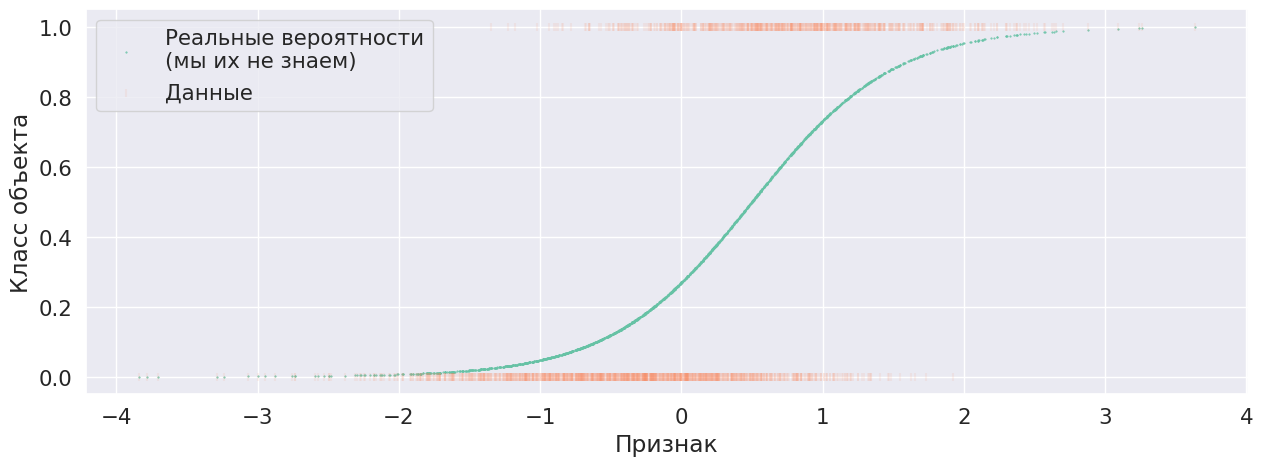

In [11]:
sample_size = 2000

X = np.random.normal(size=(sample_size, 1))

y_mean_true = 1 / (1 + np.exp(1 - 2*X.ravel()))
y = np.random.binomial(n=1, p=y_mean_true)

plt.figure(figsize=(15, 5))
plt.scatter(X, y_mean_true, marker='.', s=1, label='Реальные вероятности\n(мы их не знаем)')
plt.scatter(X, y, marker='|', alpha=0.1, label='Данные')
plt.xlabel('Признак')
plt.ylabel('Класс объекта')
plt.legend();

Реализуем свою собственную версию

In [36]:
class LogisticRegression():

    def __init__(self, alpha=0, lr=0.5, eps=1e-3, max_iter=1e5,
                 method='gd', criterion='max_iter',
                 fit_intercept=True, save_history=True, batch_size=10):
        '''Создает модель и инициализирует параметры.'''

        criterion_error_msg = 'выбран неправильный критерий остановки'
        assert criterion in ['max_iter', 'eps'], criterion_error_msg

        method_error_msg = 'выбран неправильный метод'
        assert method in ['gd', 'sgd', 'irls'], method_error_msg

        self.alpha = alpha
        self.lr = lr
        self.eps = eps
        self.max_iter = max_iter
        self.criterion = criterion
        self.method = method
        self.fit_intercept = fit_intercept
        self.save_history = save_history
        self.history = []  # для хранения истории обучения
        self.batch_size = batch_size


    @staticmethod
    def _sigmoid(x):
        '''Cигмоида.'''

        # применим exp-normalize trick для вычисления
        return np.where(x >= 0, 1 / (1 + np.exp(-x)),
                        np.exp(x) / (1 + np.exp(x)))


    def _log_likelihood(self, X, y):
        '''Логарифм функции правдоподобия.'''

        # применим log-sum-exp trick для вычисления
        exponent = np.zeros((X.shape[0], 2))
        exponent[:, 1] = X @ self.weights
        log_sigma = -scipy.special.logsumexp(-exponent, axis=1)
        log_one_minus_sigma = -scipy.special.logsumexp(exponent, axis=1)

        return np.mean(y * log_sigma + (1 - y) * log_one_minus_sigma)


    def _add_intercept(self, X):
        X_copy = np.full((X.shape[0], X.shape[1] + 1), fill_value=1.0)
        X_copy[:, :-1] = X

        return X_copy


    def fit(self, X, Y):
        assert X.shape[0] == Y.shape[0]

         # добавляем свободный коэфициент
        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()
        n, d = X_copy.shape

        # инициализируем коэфициенты
        if self.method == 'irls':
            self.weights = np.zeros(X_copy.shape[1])
        else:
            self.weights = sps.uniform(-1, 2).rvs(X_copy.shape[1])

        # произведенное число итераций
        self.n_iter_ = 0

        prev_coefs = next_coefs = self.weights

        while True:
            if self.save_history: start_time = time()  # засекаем время

            prev_coefs = next_coefs

            # выбираем индексы элементов, по которым будем считать
            # градиент на текущей итерации
            if self.method == 'sgd':
                ind = np.random.choice(n, size=self.batch_size)
            else:
                ind = np.arange(n)

            # считаем градиент
            S = self._sigmoid(X_copy[ind] @ prev_coefs)
            grad = X_copy[ind].T @ (Y[ind] - S) - self.alpha*prev_coefs

            if self.method in ['sgd', 'gd']:
                # обновляем коэфициенты по методу градиентного спуска
                next_coefs = prev_coefs + self.lr * grad
            else:
                # считаем гессиан и обновляем коэфициенты по методу IRLS
                V = np.diag(S.ravel() * (1 - S.ravel()))
                hess_inv = np.linalg.inv(
                    X_copy.T @ V @ X_copy + max(self.alpha, 1e-3)*np.eye(d)
                )
                next_coefs = prev_coefs + hess_inv @ grad

            self.n_iter_ += 1

            # проверяем критерий останова
            if (
                self.criterion == 'max_iter'
                and self.n_iter_ > self.max_iter
            ):
                break

            if (
                self.criterion == 'eps'
                and np.linalg.norm(prev_coefs - next_coefs, ord=2) < self.eps
            ):
                break

            self.weights = next_coefs

            # сохраняем историю обучения
            if self.save_history:
                end_time = time()
                self.history.append(
                    (self._log_likelihood(X_copy, Y),
                     end_time - start_time)
                )

        if self.fit_intercept:
            self.coef_ = self.weights[:-1]  # коэффициенты модели
            self.intercept_ = self.weights[-1]  # свободный коэффициент
        else:
            self.coef_ = self.weights
            self.intercept_ = None

        return self


    def predict(self, X):
        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]

        predicted = np.full(X.shape[0], fill_value=0)
        predicted[X_copy @ self.weights > 0] = 1

        return predicted


    def predict_proba(self, X):
        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]

        prob_predictions = np.zeros((X.shape[0], 2))
        prob_predictions[:, 1] = self._sigmoid(X_copy @ self.weights)
        prob_predictions[:, 0] = 1 - prob_predictions[:, 1]

        return prob_predictions

Загрузим данные

In [29]:
dataset = load_breast_cancer()
dataset['DESCR'].split('\n')[11:31]

[':Attribute Information:',
 '    - radius (mean of distances from center to points on the perimeter)',
 '    - texture (standard deviation of gray-scale values)',
 '    - perimeter',
 '    - area',
 '    - smoothness (local variation in radius lengths)',
 '    - compactness (perimeter^2 / area - 1.0)',
 '    - concavity (severity of concave portions of the contour)',
 '    - concave points (number of concave portions of the contour)',
 '    - symmetry',
 '    - fractal dimension ("coastline approximation" - 1)',
 '',
 '    The mean, standard error, and "worst" or largest (mean of the three',
 '    worst/largest values) of these features were computed for each image,',
 '    resulting in 30 features.  For instance, field 0 is Mean Radius, field',
 '    10 is Radius SE, field 20 is Worst Radius.',
 '',
 '    - class:',
 '            - WDBC-Malignant',
 '            - WDBC-Benign']

Разделим на train и test

In [30]:
X, Y = dataset['data'], dataset['target']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((455, 30), (114, 30), (455,), (114,))

Применим стандартизацию

In [31]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Теперь обучим логичтичскую регрессию для каждого из описанных выше итеративных типов сходимости

In [37]:
k = 10
np.random.seed(42)
methods = ['gd', 'sgd', 'irls']
histories = {}

In [38]:
# цикл по методам
for method in methods:
    histories_method = []
    for i in range(k):
        # обучение модели
        clf = LogisticRegression(
            alpha=0, lr=1e-2, eps=1e-3, max_iter=2e3, method=method,
            criterion='max_iter', fit_intercept=True, save_history=True
        )
        clf.fit(X_train, Y_train)
        histories_method.append(clf.history)
    histories[method] = histories_method

Усредним результаты по $k$ запускам

In [39]:
mean_scores = {}
for method in methods:
    histories_method = histories[method]
    history_scores = np.array(
        [[x[0] for x in history_method]
         for history_method in histories_method]
    )
    mean_scores[method] = np.mean(history_scores, axis=0)

Отрисуем результаты

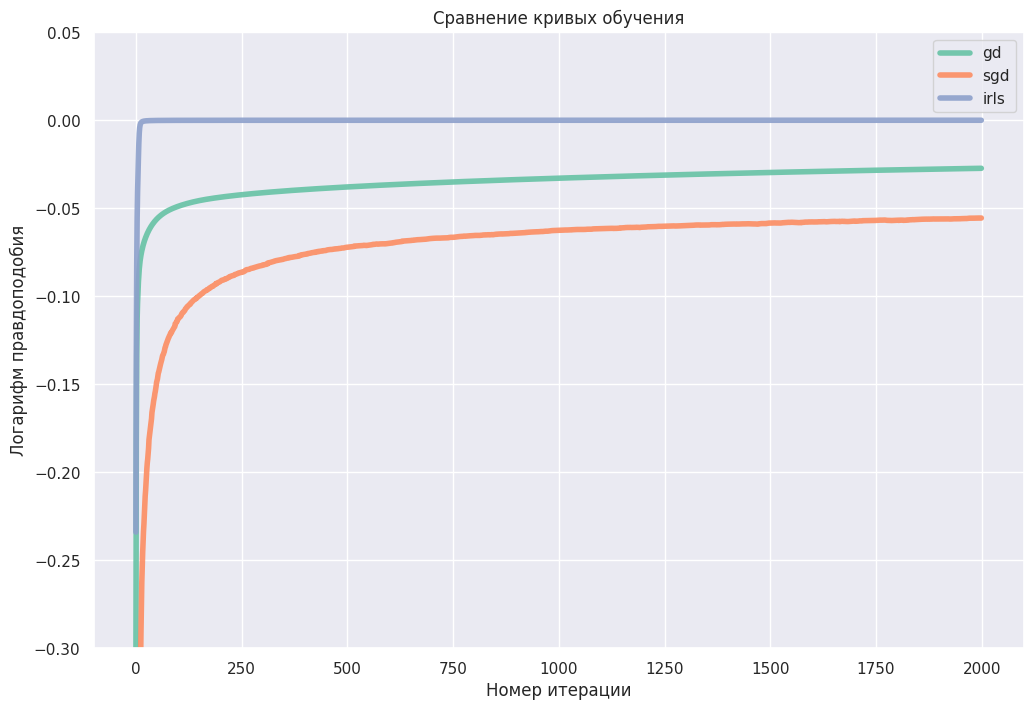

In [40]:
plt.figure(figsize=(12, 8))
plt.title('Сравнение кривых обучения')

for method in ['gd', 'sgd', 'irls']:
    plt.plot(mean_scores[method], label=method, lw=4, alpha=0.9)

plt.xlabel('Номер итерации')
plt.ylabel('Логарифм правдоподобия')
plt.ylim((-0.3, 0.05))
plt.legend()
plt.show()

Теперь сделаем визуализацию времени работы

In [41]:
time_values = {}
for method in methods:
    histories_method = histories[method]
    history_times = np.array(
        [[x[1] for x in history_method]
         for history_method in histories_method]
    )
    time_values[method] = np.cumsum(np.mean(history_times, axis=0))

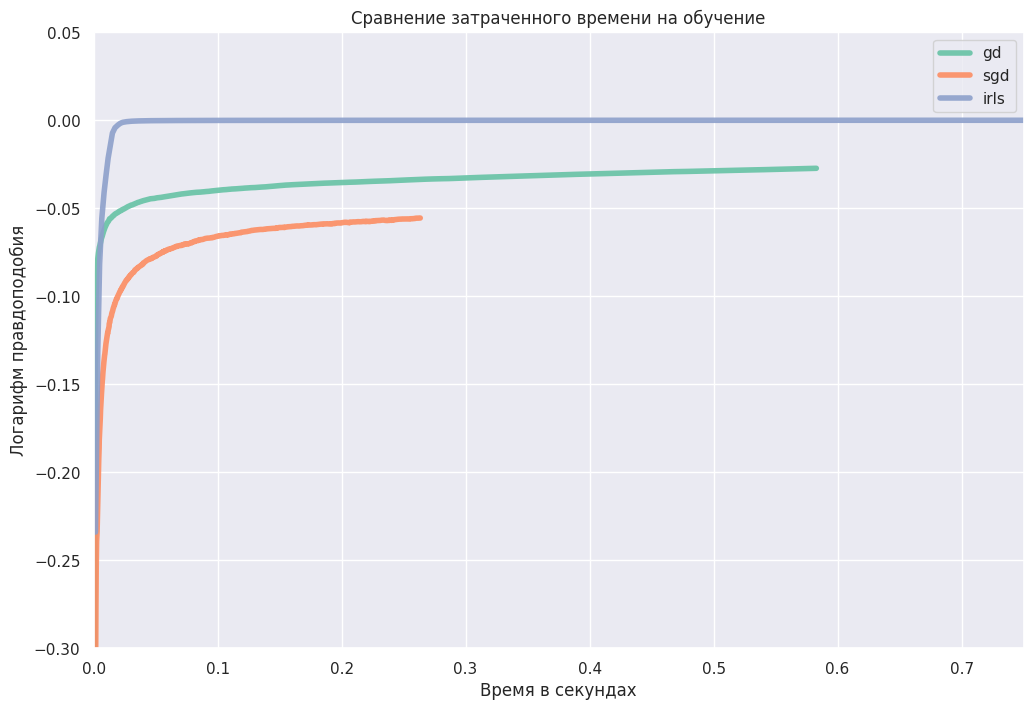

In [42]:
plt.figure(figsize=(12, 8))
plt.title('Сравнение затраченного времени на обучение')

for method in ['gd', 'sgd', 'irls']:
    plt.plot(time_values[method], mean_scores[method], label=method, lw=4,
             alpha=0.9)

plt.xlabel('Время в секундах')
plt.ylabel('Логарифм правдоподобия')
plt.ylim((-0.3, 0.05))
plt.xlim((0, 0.75))
plt.legend()
plt.show()

Сравним два реализованных критерия остановки по количеству проведенных итераций:
* евклидова норма разности текущего и нового векторов весов стала меньше, чем $10^{-4}$
* ограничение на число итераций (например, $10000$)

Будем использвать градиентный спуск

In [43]:
np.random.seed(42)
clf = LogisticRegression(
    criterion='eps', method='gd', eps=1e-4, lr=1e-4
)
clf.fit(X_train, Y_train)

print('Потребовалось {} итераций, чтобы сойтись.'.format(clf.n_iter_))

Потребовалось 27233 итераций, чтобы сойтись.


Теперь рассматрим зависимость Accuracy от learning rate

In [44]:
k = 5
lrs = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10]

accuracy_values = []
loss_values = []

np.random.seed(42)
for lr in lrs:
    accuracy_values_lr = []
    for i in range(k):
        clf = LogisticRegression(lr=lr, max_iter=10000,
                                 criterion='max_iter', method='sgd')
        clf.fit(X_train, Y_train)

        accuracy_values_lr.append(
            accuracy_score(Y_test, clf.predict(X_test))
        )
        if i == 0:
            loss_values.append(np.array(clf.history)[:, 0])
    accuracy_values.append(np.mean(accuracy_values_lr))

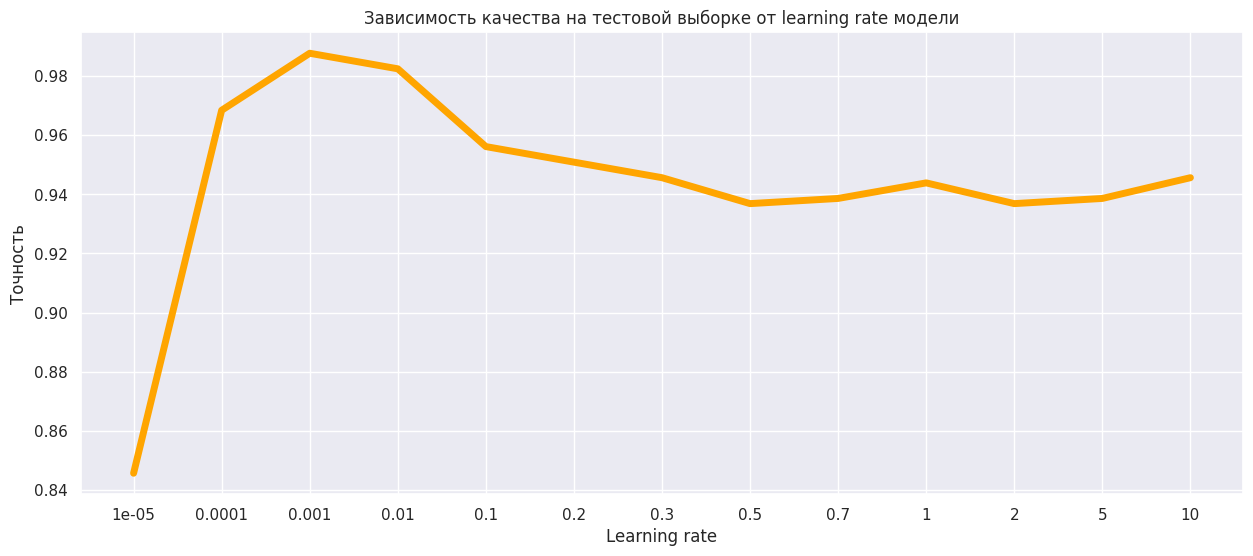

In [45]:
plt.figure(figsize=(15, 6))
plt.title('Зависимость качества на тестовой выборке от learning rate модели')
plt.plot(accuracy_values, lw=5, color='orange')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.xticks(ticks=np.arange(len(lrs)), labels=lrs)
plt.show()

Теперь рассмотрим кривые обучения для каждого различных значений lr

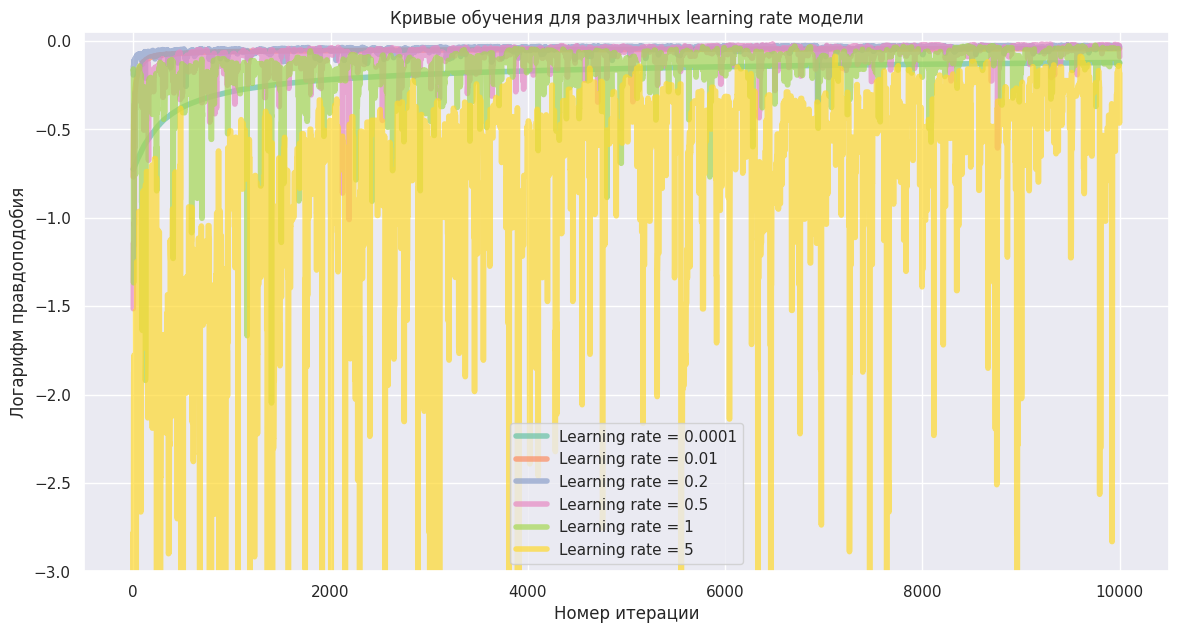

In [46]:
plt.figure(figsize=(14, 7))
plt.title('Кривые обучения для различных learning rate модели')

for loss, lr in zip(loss_values[1:-1:2], lrs[1:-1:2]):
    plt.plot(loss, label='Learning rate = {}'.format(lr), alpha=0.7, lw=4)

plt.xlabel('Номер итерации')
plt.ylabel('Логарифм правдоподобия')
plt.ylim((-3, 0.05))
plt.legend()
plt.show()

Теперь изучим модель при изменении параметра регуляризации

In [47]:
iters_values = []
accuracy_values = []
k = 5
np.random.seed(17)
coefs = np.append([0], np.logspace(-5, 3, 9))

for coef in coefs:
    iters_values_cur = []
    accuracy_values_cur = []
    for i in range(k):
        clf = LogisticRegression(alpha=coef, lr=0.001, method='gd',
                                 criterion='eps', eps=1e-3)
        clf.fit(X_train, Y_train)

        iters_values_cur.append(clf.n_iter_)
        accuracy_values_cur.append(
            accuracy_score(Y_test, clf.predict(X_test))
        )
    iters_values.append(np.mean(iters_values_cur))
    accuracy_values.append(np.mean(accuracy_values_cur))

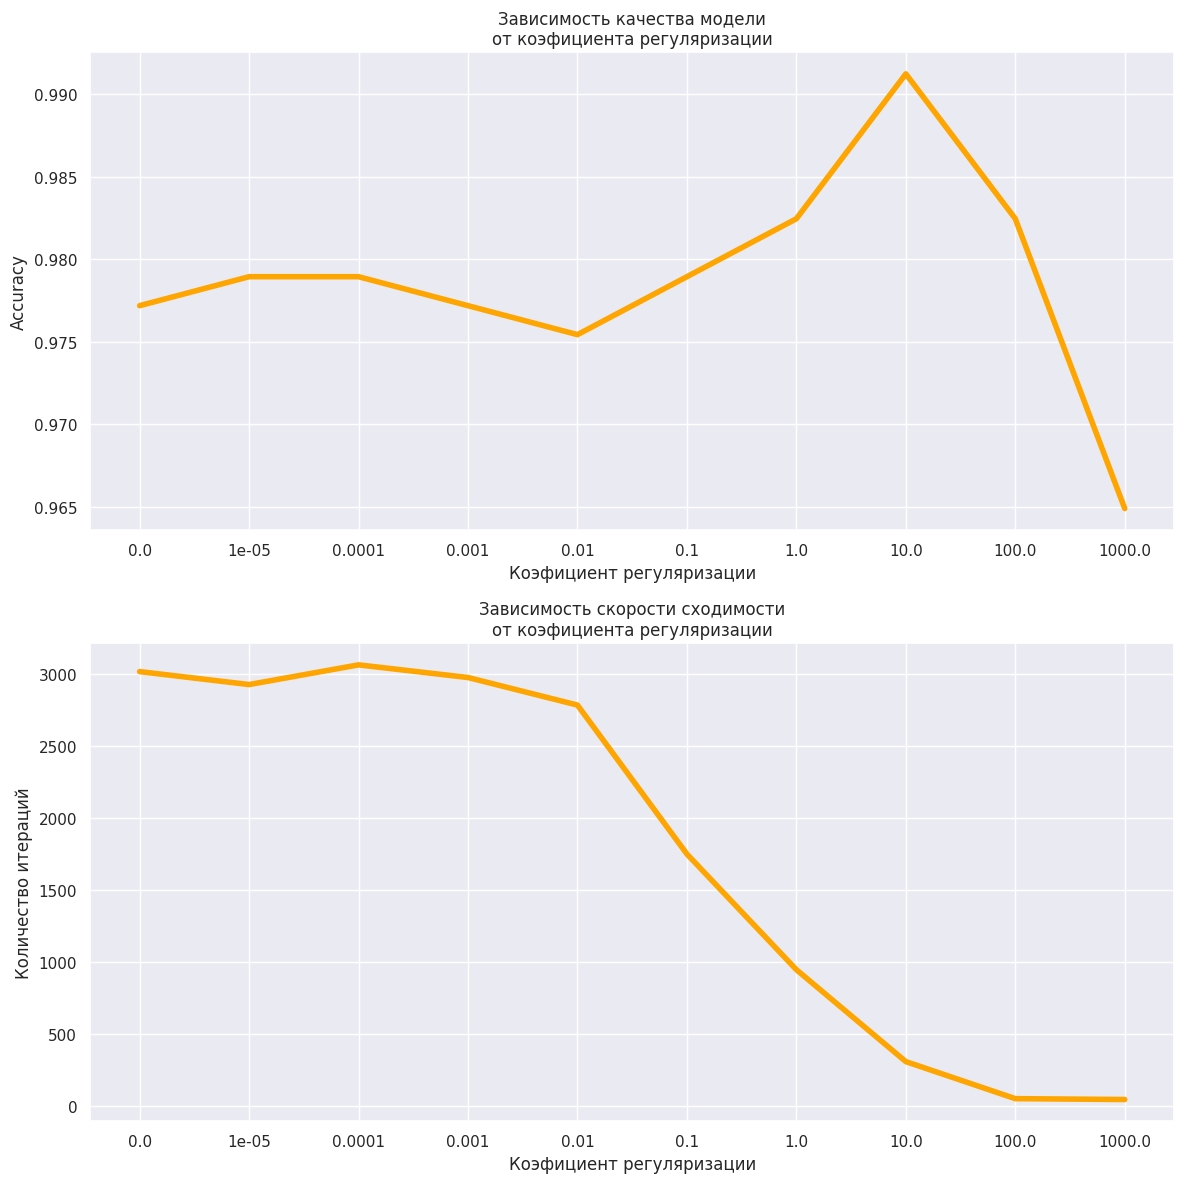

In [52]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.title('Зависимость качества модели\nот коэфициента регуляризации')
plt.plot(accuracy_values, lw=4, color='orange')
plt.xlabel('Коэфициент регуляризации')
plt.ylabel('Accuracy')
plt.xticks(ticks=np.arange(len(coefs)), labels=coefs)

plt.subplot(2, 1, 2)
plt.title('Зависимость скорости сходимости\nот коэфициента регуляризации')
plt.plot(iters_values, lw=4, color='orange')
plt.xlabel('Коэфициент регуляризации')
plt.ylabel('Количество итераций')
plt.xticks(ticks=np.arange(len(coefs)), labels=coefs)

plt.tight_layout()
plt.show()

Возьмем лучшую модель с предыдущих итераций

А также выберем два признака для более удобной вищуализации

In [49]:
clf = LogisticRegression(alpha=10, lr=0.001, method='gd',
                         criterion='eps', eps=1e-3,
                         fit_intercept=False)
clf.fit(X_train[:, [20, 27]], Y_train)

Рассмотрим визуализацию предсказаний

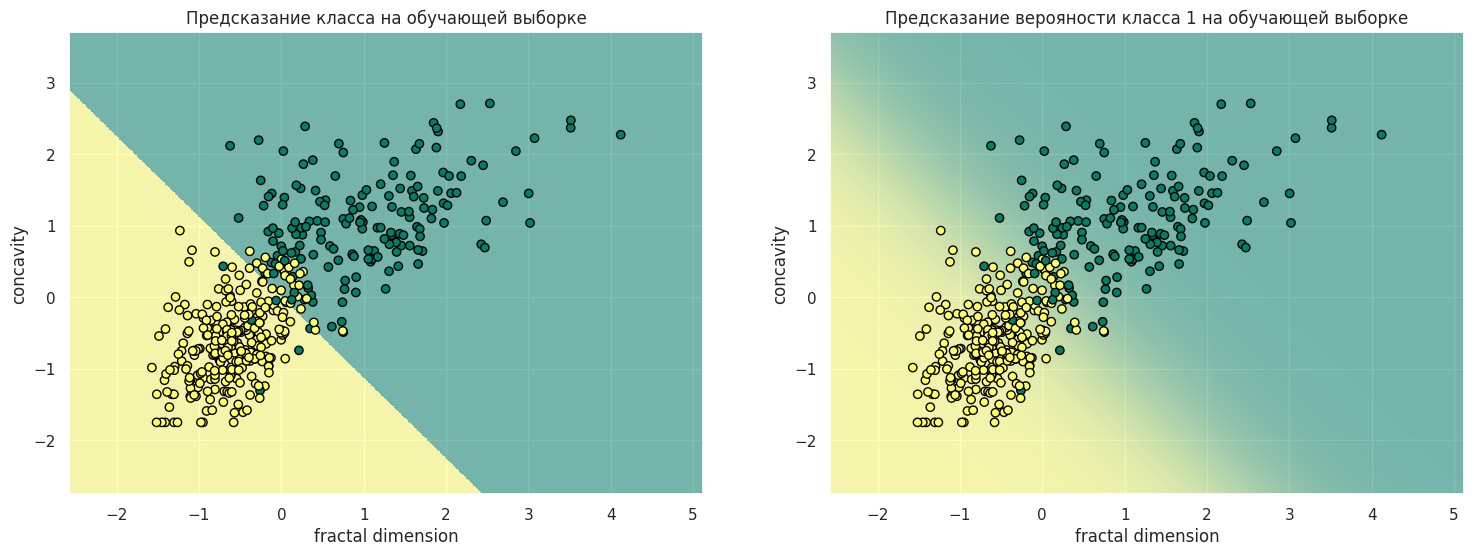

In [54]:
plt.figure(figsize=(18, 6))

# сетка для отрисовки графиков
x_min, x_max = X_train[:, 20].min() - 1, X_train[:, 20].max() + 1
y_min, y_max = X_train[:, 27].min() - 1, X_train[:, 27].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

plt.subplot(1, 2, 1)
plt.title('Предсказание класса на обучающей выборке')
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap='summer', alpha=0.5)
plt.scatter(X_train[:, 20], X_train[:, 27], c=Y_train,
            cmap='summer', edgecolors='black')
plt.xlabel('fractal dimension'), plt.ylabel('concavity');

plt.subplot(1, 2, 2)
plt.title('Предсказание верояности класса 1 на обучающей выборке')
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap='summer', alpha=0.5)
plt.scatter(X_train[:, 20], X_train[:, 27], c=Y_train,
            cmap='summer', edgecolors='black')
plt.xlabel('fractal dimension'), plt.ylabel('concavity');

plt.show()

И то же самое для тестовой выборки

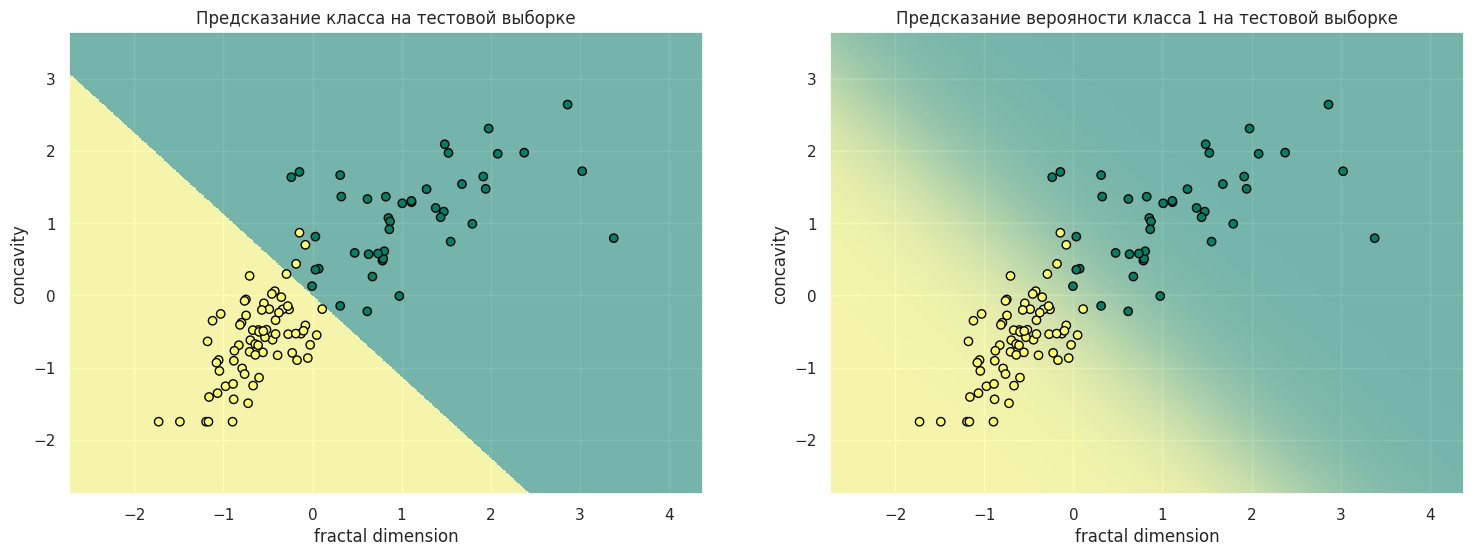

In [51]:
plt.figure(figsize=(18, 6))

# сетка для отрисовки графиков
x_min, x_max = X_test[:, 20].min() - 1, X_test[:, 20].max() + 1
y_min, y_max = X_test[:, 27].min() - 1, X_test[:, 27].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

plt.subplot(1, 2, 1)
plt.title('Предсказание класса на тестовой выборке')
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap='summer', alpha=0.5)
plt.scatter(X_test[:, 20], X_test[:, 27], c=Y_test,
            cmap='summer', edgecolors='black')
plt.xlabel('fractal dimension'), plt.ylabel('concavity');

plt.subplot(1, 2, 2)
plt.title('Предсказание верояности класса 1 на тестовой выборке')
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap='summer', alpha=0.5)
plt.scatter(X_test[:, 20], X_test[:, 27], c=Y_test,
            cmap='summer', edgecolors='black')
plt.xlabel('fractal dimension'), plt.ylabel('concavity');

plt.show()